In [29]:
from collections import defaultdict
import pandas as pd
import pickle as pkl
import os


def get_evidence_df(ann_folder):
    rows = {}
    for filename in os.listdir(ann_folder):
        with open(os.path.join(ann_folder, filename), 'rb') as f:
            d = pkl.load(f)
            instance_data = next(iter(d.values()))
            anns = instance_data['model_anns']
            if len(anns) > 0:
                assert len(anns) == 1
                model_type = next(iter(anns.keys()))
                anns['model_type'] = model_type
                model_anns = anns[model_type]
                if len(model_anns) > 0:
                    assert len(model_anns['sort_by_model_order']) == 1
                    sort_type = model_anns['sort_by_model_order'][0]
                    anns['sort_type'] = sort_type
                    del model_anns['sort_by_model_order']
                    model_anns['evidence_anns'] = model_anns['evidence_anns'][sort_type]
                    anns.update(model_anns)
                del anns[model_type]
            del instance_data['model_anns']
            instance_data.update(instance_data['info'])
            del instance_data['info']
            instance_data.update(anns)
            rows.update(d)
    return pd.DataFrame(rows).transpose().sort_index()

def get_full_evidence_df(ann_dirs):
    dfs = defaultdict(lambda : pd.DataFrame([]))
    for ann_dir in ann_dirs:
        for split in os.listdir(ann_dir):
            for annotator in os.listdir(os.path.join(ann_dir, split)):
                df = get_evidence_df(os.path.join(ann_dir, split, annotator))
                df['annotator'] = [annotator] * len(df)
                dfs[split] = pd.concat([dfs[split], df])
    return dict(dfs)


In [30]:
dfs = get_full_evidence_df([
    '/work/frink/mcinerney.de/ehr-diagnosis-annotations/annotations_9-29-23/annotations',
    '/work/frink/mcinerney.de/ehr-diagnosis-annotations/annotations_11-3-23/annotations',])

In [31]:

dfs['val2']

,obs,timestep,num_reports,instance,time_for_initial_assesment,seen_targets,option_likelihood_anns,max_timesteps,true_positives,current_targets,...,sort_type,prediction_aligns,evidence_anns,options,selected_options,option_likelihood_anns2,concluding_notes,invalid_instance_notes,annotator,action
0,"{'options': 'option,type cancer,diagnosis pneu...",1,26,"val2 Instance 50 (patient 11755, 122 reports)",168.272657,{},"{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",19,None,"{pneumonia, pulmonary edema}",...,LLM Confidence,Yes,{10: {'cancer': {'relevance': '1 - Weak Correl...,"[cancer (diagnosis), pneumonia (diagnosis), pu...","[0, 1, 2]","{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",,NaN,Andrea,NaN
1,"{'options': 'option,type cancer,diagnosis pneu...",1,42,"val2 Instance 51 (patient 7470, 53 reports)",189.534721,{pulmonary edema (diagnosis)},NaN,21,None,{},...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,Andrea,NaN
2,"{'options': 'option,type cancer,diagnosis pneu...",1,1,"val2 Instance 52 (patient 83375, 8 reports)",24.683878,{},"{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",7,None,{pulmonary edema},...,LLM Confidence,No,"{1: {'cancer': {'relevance': '0 - Not Useful',...","[cancer (diagnosis), pneumonia (diagnosis), pu...","[0, 1, 2]","{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",,NaN,Andrea,NaN
3,"{'options': 'option,type cancer,diagnosis pneu...",1,2,"val2 Instance 53 (patient 94023, 4 reports)",29.90608,{},"{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",3,None,{},...,LLM Confidence,Yes,"{1: {'cancer': {'relevance': '0 - Not Useful',...","[cancer (diagnosis), pneumonia (diagnosis), pu...","[0, 1, 2]","{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",,NaN,Andrea,NaN
4,"{'options': 'option,type cancer,diagnosis pneu...",1,2,"val2 Instance 54 (patient 26310, 32 reports)",46.365206,{},"{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",3,None,{pulmonary edema},...,Sort by MSE with the bias logits,No,"{0: {'cancer': {'relevance': '0 - Not Useful',...","[cancer (diagnosis), pneumonia (diagnosis), pu...","[0, 1, 2]","{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",,NaN,Andrea,NaN
5,"{'options': 'option,type cancer,diagnosis pneu...",1,24,"val2 Instance 55 (patient 5255, 25 reports)",158.251378,{cancer (diagnosis)},NaN,1,None,{cancer},...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,Andrea,NaN
1,"{'options': 'option,type cancer,diagnosis pneu...",1,12,"val2 Instance 67 (patient 1973, 36 reports)",45.904525,{},"{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",39,None,{pulmonary edema},...,LLM Confidence,Yes,{18: {'cancer': {'relevance': '0 - Not Useful'...,"[cancer (diagnosis), pneumonia (diagnosis), pu...","[0, 1, 2]","{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",,NaN,Andrea,"[-3.8275794982910156, -1.8324410915374756, -1...."
2,"{'options': 'option,type cancer,diagnosis pneu...",1,10,"val2 Instance 69 (patient 11480, 158 reports)",155.551828,{},"{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",295,None,{},...,Sort by MSE with the bias logits,No,{145: {'cancer': {'relevance': '0 - Not Useful...,"[cancer (diagnosis), pneumonia (diagnosis), pu...","[0, 1, 2]","{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",,NaN,Andrea,"[-5.879974842071533, -1.8629225492477417, -2.7..."
3,"{'options': 'option,type cancer,diagnosis pneu...",1,11,"val2 Instance 76 (patient 7097, 16 reports)",98.346124,{},"{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",9,None,{},...,Sort by MSE with the bias logits,No,{104: {'cancer': {'relevance': '0 - Not Useful...,"[cancer (diagnosis), pneumonia (diagnosis), pu...","[0, 1, 2]","{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",,NaN,Andrea,"[-4.060123443603516, -2.017209529876709, -1.12..."
4,"{'options': 'option,type cancer,diagnosis pneu...",1,17,"val2 Instance 85 (patient 19303, 52 reports)",89.775001,{},"{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",15,None,{pulmonary edema},...,LLM Confidence,Yes,{15: {'cancer': {'relevance': '0 - Not Useful'...,"[cancer (diagnosis), pneumonia (diagnosis), pu...","[

In [37]:
from collections import defaultdict
def get_processed_annotations(df):
    new_rows = []
    for i, row in df.iterrows():
        new_rows.append({
            'annotator': row['annotator'],
            'instance_index': row['instance_index'],
            'num_reports': row['num_reports'],
            'model_type': row['model_type'],
            'sort_type': row['sort_type'],
            'prediction_aligns': row['prediction_aligns'],
            'time_for_initial_assesment': row['time_for_initial_assesment'],
        })
        if row['options'] == row['options']:
            for condition in row['options']:
                condition = condition.split(' (')[0]
                new_rows[-1][condition + ' in future'] = condition in row['future_true_positives']
            evidence_anns = sorted([{'idx': k, **v} for k, v in row['evidence_anns'].items()], key=lambda x: x['sorted_idx'])
            new_evidence_anns = defaultdict(lambda: [])
            new_rows[-1]['num_annotated_evidence'] = len(evidence_anns)
            for x in evidence_anns:
                evidence_info = x['evidence']
                for k, v in evidence_info.items():
                    if k == 'evidence':
                        continue
                    new_evidence_anns[k].append(v)
                new_evidence_anns['evidence_was_seen'].append(
                    x['evidence_was_seen'] if 'evidence_was_seen' in x.keys() else None)
                for condition in row['options']:
                    condition = condition.split(' (')[0]
                    new_evidence_anns[condition + ' relevance'].append(int(
                        x[condition]['relevance'].split()[0]))
                    new_evidence_anns[condition + ' impact'].append(
                        x[condition]['impact'] if 'impact' in x[condition].keys()
                        else None)
            new_rows[-1].update(new_evidence_anns)
        if row['option_likelihood_anns'] == row['option_likelihood_anns']:
            new_rows[-1].update({k.split(' (')[0]: v for k, v in row['option_likelihood_anns'].items()})
            new_rows[-1].update({k.split(' (')[0] + '(changed)': v for k, v in row['option_likelihood_anns2'].items() if v != row['option_likelihood_anns'][k]})
    new_df = pd.DataFrame(new_rows)
    return new_df


In [44]:
processed_df = get_processed_annotations(dfs['val2'])
processed_df

,annotator,instance_index,num_reports,model_type,sort_type,prediction_aligns,time_for_initial_assesment,cancer in future,pneumonia in future,pulmonary edema in future,...,cancer relevance,cancer impact,pneumonia relevance,pneumonia impact,pulmonary edema relevance,pulmonary edema impact,cancer,pneumonia,pulmonary edema,cancer(changed)
0,Andrea,49,26,llm_evidence,LLM Confidence,Yes,168.272657,False,True,True,...,[1],[Yes],[1],[Yes],[1],[Yes],Unlikely,Somewhat likely,Somewhat likely,NaN
1,Andrea,50,42,llm_evidence,NaN,NaN,189.534721,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Andrea,51,1,llm_evidence,LLM Confidence,No,24.683878,False,False,True,...,"[0, 0]","[None, None]","[1, 0]","[No, None]","[1, 0]","[No, None]",Unlikely,Unlikely,Unlikely,NaN
3,Andrea,52,2,llm_evidence,LLM Confidence,Yes,29.906080,False,False,False,...,"[0, 0, 0]","[None, None, None]","[0, 0, 0]","[None, None, None]","[0, 0, 0]","[None, None, None]",Unlikely,Unlikely,Somewhat likely,NaN
4,Andrea,53,2,llm_evidence,Sort by MSE with the bias logits,No,46.365206,False,False,True,...,[0],[None],[1],[Yes],[1],[Yes],Unlikely,Unlikely,Unlikely,NaN
5,Andrea,54,24,llm_evidence,NaN,NaN,158.251378,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Andrea,66,12,llm_evidence,LLM Confidence,Yes,45.904525,False,False,True,...,"[0, 0, 0]","[None, None, None]","[0, 0, 0]","[None, None, None]","[0, 0, 0]","[None, None, None]",Unlikely,Unlikely,Somewhat likely,NaN
7,Andrea,68,10,all_sentences,Sort by MSE with the bias logits,No,155.551828,False,False,False,...,"[0, 0]","[None, None]","[1, 1]","[No, No]","[1, 1]","[No, Yes]",Unlikely,Unlikely,Somewhat likely,NaN
8,Andrea,75,11,all_sentences,Sort by MSE with the bias logits,No,98.346124,False,False,False,...,"[0, 0, 0, 0, 0]","[None, None, None, None, None]","[0, 0, 0, 0, 0]","[None, None, None, None, None]","[0, 0, 0, 0, 0]","[None, None, None, None, None]",Unlikely,Very likely,Unlikely,NaN
9,Andrea,84,17,llm_evidence,LLM Confidence,Yes,89.775001,False,False,True,...,"[0, 0]","[None, None]","[0, 0]","[None, None]","[0, 0]","[None, None]",Unlikely,Unlikely,Unlikely,NaN


In [39]:
processed_df.keys()

Index(['annotator', 'instance_index', 'num_reports', 'model_type', 'sort_type',
       'prediction_aligns', 'time_for_initial_assesment', 'cancer in future',
       'pneumonia in future', 'pulmonary edema in future',
       'num_annotated_evidence', 'score', 'query', 'day', 'report_number',
       'evidence_was_seen', 'cancer relevance', 'cancer impact',
       'pneumonia relevance', 'pneumonia impact', 'pulmonary edema relevance',
       'pulmonary edema impact', 'cancer', 'pneumonia', 'pulmonary edema',
       'cancer(changed)'],
      dtype='object')

<Axes: xlabel='num_reports', ylabel='time_for_initial_assesment'>

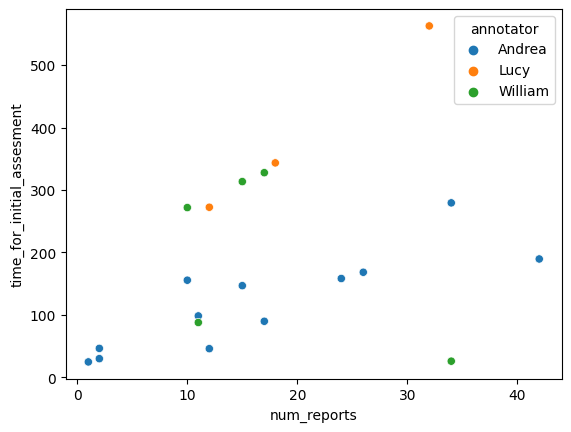

In [40]:
import seaborn as sns
sns.scatterplot(data=processed_df, x='num_reports', y='time_for_initial_assesment', hue='annotator')

In [71]:
from collections import Counter
instance_counts = []
for i, row in processed_df.iterrows():
    if row['sort_type'] != row['sort_type']:
        continue
    instance_counts.append(Counter())
    relevance_keys = [k for k in row.keys() if k.endswith(' relevance')]
    if row[relevance_keys[0]] == row[relevance_keys[0]]:
        for x in zip(*[row[k] for k in relevance_keys]):
            instance_counts[-1][max(x)] += 1
    instance_counts[-1] = dict(instance_counts[-1])
    instance_counts[-1]['annotator'] = row['annotator']
    instance_counts[-1]['model'] = (row['model_type'], row['sort_type'])
    instance_counts[-1]['instance_index'] = row['instance_index']
instance_counts = pd.DataFrame(instance_counts)
instance_counts

,1,annotator,model,instance_index,0,2,3
0,1.0,Andrea,"(llm_evidence, LLM Confidence)",49,NaN,NaN,NaN
1,1.0,Andrea,"(llm_evidence, LLM Confidence)",51,1.0,NaN,NaN
2,NaN,Andrea,"(llm_evidence, LLM Confidence)",52,3.0,NaN,NaN
3,1.0,Andrea,"(llm_evidence, Sort by MSE with the bias logits)",53,NaN,NaN,NaN
4,NaN,Andrea,"(llm_evidence, LLM Confidence)",66,3.0,NaN,NaN
5,2.0,Andrea,"(all_sentences, Sort by MSE with the bias logits)",68,NaN,NaN,NaN
6,NaN,Andrea,"(all_sentences, Sort by MSE with the bias logits)",75,5.0,NaN,NaN
7,NaN,Andrea,"(llm_evidence, LLM Confidence)",84,2.0,NaN,NaN
8,1.0,Andrea,"(all_sentences, Sort by MSE with the bias logits)",86,1.0,1.0,NaN
9,NaN,Andrea,"(llm_evidence, Sort by MSE with the bias logits)",94,NaN,NaN,2.0


In [72]:
import numpy as np
instance_counts_expanded = pd.DataFrame([])
for x in range(4):
    df = instance_counts[[c for c in instance_counts.columns if not isinstance(c, int)]]
    df['count'] = instance_counts[x]
    df['max_usefulness'] = [x] * len(df)
    instance_counts_expanded = pd.concat([instance_counts_expanded, df])
instance_counts_expanded = instance_counts_expanded.sort_values('instance_index')
instance_counts_expanded

/tmp/ipykernel_45920/1565988942.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['count'] = instance_counts[x]
/tmp/ipykernel_45920/1565988942.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['max_usefulness'] = [x] * len(df)
/tmp/ipykernel_45920/1565988942.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

,annotator,model,instance_index,count,max_usefulness
10,Lucy,"(llm_evidence, Sort by MSE with the bias logits)",0,NaN,1
10,Lucy,"(llm_evidence, Sort by MSE with the bias logits)",0,3.0,2
10,Lucy,"(llm_evidence, Sort by MSE with the bias logits)",0,1.0,0
10,Lucy,"(llm_evidence, Sort by MSE with the bias logits)",0,NaN,3
0,Andrea,"(llm_evidence, LLM Confidence)",49,NaN,2
...,...,...,...,...,...
9,Andrea,"(llm_evidence, Sort by MSE with the bias logits)",94,NaN,1
16,William,"(all_sentences, Sort by MSE with the bias logits)",94,NaN,0
9,Andrea,"(llm_evidence, Sort by MSE with the bias logits)",94,NaN,0
9,Andrea,"(llm_evidence, Sort by MSE with the bias logits)",94,2.0,3


In [110]:
df = instance_counts_expanded.groupby(['max_usefulness', 'model', 'annotator', 'instance_index']).agg({'count': np.sum}).reset_index()
df['model'] = df['model'].astype(str)
print({model: set(df[df.model == model].annotator) for model in set(df.model)})
# df = df.groupby(['max_usefulness', 'model']).agg({'count': lambda x: (x.mean(), x.std())}).reset_index()
# df['count (averaged over annotators)'] = df['count'].apply(lambda x: x[0])
# df['count stddev'] = df['count'].apply(lambda x: x[1])
df

{"('all_sentences', 'Sort by MSE with the bias logits')": {'Andrea', 'William'}, "('llm_evidence', 'Sort by MSE with the bias logits')": {'Andrea', 'William', 'Lucy'}, "('llm_evidence', 'LLM Confidence')": {'Andrea', 'William'}}


,max_usefulness,model,annotator,instance_index,count
0,0,"('all_sentences', 'Sort by MSE with the bias l...",Andrea,68,0.0
1,0,"('all_sentences', 'Sort by MSE with the bias l...",Andrea,75,5.0
2,0,"('all_sentences', 'Sort by MSE with the bias l...",Andrea,86,1.0
3,0,"('all_sentences', 'Sort by MSE with the bias l...",William,84,2.0
4,0,"('all_sentences', 'Sort by MSE with the bias l...",William,94,0.0
...,...,...,...,...,...
63,3,"('llm_evidence', 'Sort by MSE with the bias lo...",Andrea,94,2.0
64,3,"('llm_evidence', 'Sort by MSE with the bias lo...",Lucy,0,0.0
65,3,"('llm_evidence', 'Sort by MSE with the bias lo...",Lucy,62,0.0
66,3,"('llm_evidence', 'Sort by MSE with the bias lo...",Lucy,66,1.0


<Axes: xlabel='max_usefulness', ylabel='count'>

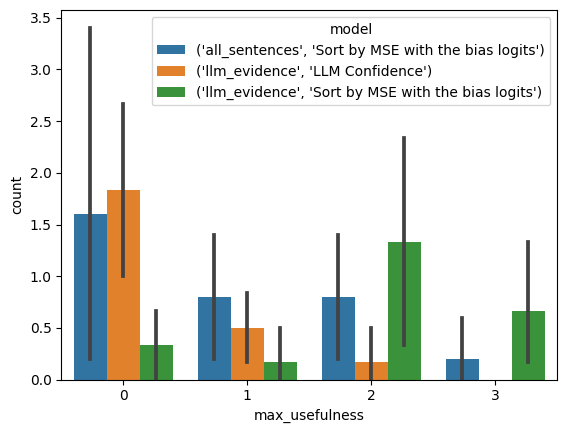

In [111]:
sns.barplot(data=df, x='max_usefulness', y='count', hue='model')

[Text(0, 0, "('all_sentences', 'Sort by MSE with the bias logits')"),
 Text(1, 0, "('llm_evidence', 'LLM Confidence')"),
 Text(2, 0, "('llm_evidence', 'Sort by MSE with the bias logits')")]

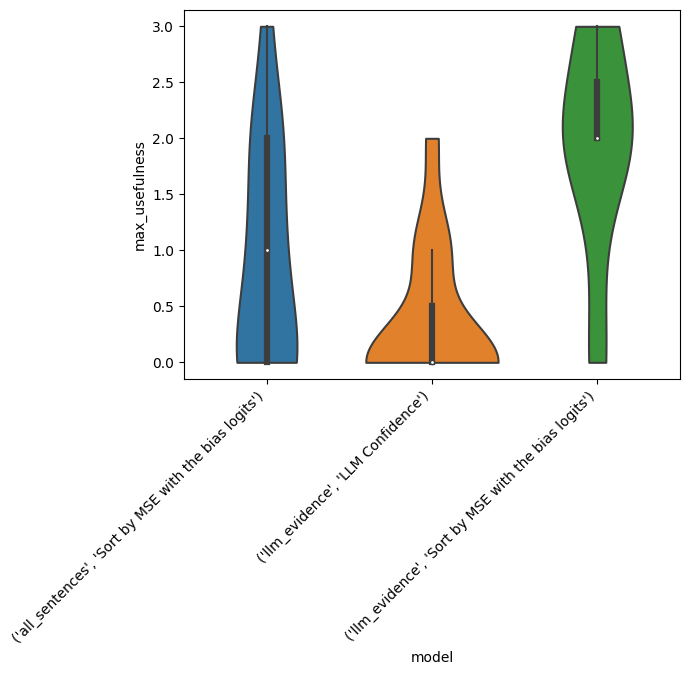

In [132]:
df_expanded = []
for i, row in df.iterrows():
    row = dict(row)
    count = row['count']
    del row['count']
    assert count.is_integer()
    for _ in range(int(count)):
        df_expanded.append(row)
df_expanded = pd.DataFrame(df_expanded)
df_expanded
chart = sns.violinplot(data=df_expanded, y='max_usefulness', x='model', cut=0)
chart.set_xticklabels(
    chart.get_xticklabels(),
    rotation=45, 
    horizontalalignment='right'
)

(\'all_sentences\', \'Sort by MSE with the bias logits\')


In [128]:
from collections import Counter
query_counts = defaultdict(lambda : Counter())
for i, row in processed_df.iterrows():
    relevance_keys = [k for k in row.keys() if k.endswith(' relevance')]
    if row[relevance_keys[0]] == row[relevance_keys[0]] and \
            row['query'] == row['query']:
        for x in zip(row['query'], *[row[k] for k in relevance_keys]):
            query_counts[x[0]][max(x[1:])] += 1
query_counts = pd.DataFrame(query_counts).transpose()
query_counts

,1,3,2,0
cancer (diagnosis),1.0,2.0,1.0,NaN
pulmonary edema (diagnosis),2.0,NaN,1.0,4.0
pneumonia (diagnosis),1.0,1.0,4.0,1.0
tiredness (risk factor),NaN,1.0,NaN,3.0
a low ejection fraction (risk factor),NaN,NaN,1.0,2.0
neuralogical problems (risk factor),NaN,NaN,NaN,1.0
a history of smoking (risk factor),NaN,NaN,NaN,1.0
jaundice (risk factor),NaN,NaN,NaN,1.0
a fever (risk factor),NaN,NaN,1.0,NaN
a compromised immune system (risk factor),NaN,NaN,1.0,NaN
